## Data Pre-Processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import haversine_distances
from math import radians
from folium.plugins import HeatMap
import folium
from sklearn.model_selection import train_test_split

In [382]:
houses_with_zipcodes = pd.read_csv('houses_with_zipcodes.csv')
population = pd.read_csv('Population Density.csv')
income = pd.read_csv('Median Household Income.csv')
poverty = pd.read_csv('Poverty Status.csv')
lat_long = pd.read_csv('houses_with_lat_long.csv')
loc = pd.read_csv('houses_with_locations_distances.csv')
year_lot = pd.read_csv('FINAL_CLEAN_DATA.csv')

In [ ]:
# merge
population = population[population['NAME'] != 'Geographic Area Name']
population['zipcode'] = population['NAME'].str.split(' ').str[1].astype(int)
houses_with_zipcodes = houses_with_zipcodes.merge(population[['zipcode','B01003_001E']], 
                                                  how='left', 
                                                  left_on='ZIP Code', 
                                                  right_on='zipcode',
                                                  )
# Rename column
houses_with_zipcodes = houses_with_zipcodes.rename(columns={'B01003_001E': 'population', 'zipcode':'zipcode_population'})



# merge tables
income['zipcode'] = income['NAME'].apply(lambda x: x.split(' ')[1] if len(x.split(' ')) == 2 and x.split(' ')[1].isdigit() else None)

# Drop rows with no zip
income = income.dropna(subset=['zipcode'])
income['zipcode'] = income['zipcode'].astype(int)
houses_with_zipcodes = houses_with_zipcodes.merge(income[['zipcode','B19013_001E']], 
                                                  how='left', 
                                                  left_on='ZIP Code', 
                                                  right_on='zipcode',
                                                  suffixes = ('','_income'))
houses_with_zipcodes = houses_with_zipcodes.rename(columns = {'B19013_001E': 'income', 'zipcode':'zipcode_income'})
houses_with_zipcodes = houses_with_zipcodes[houses_with_zipcodes['income'] != '-'] 



# Concatenate with poverty population
poverty = poverty[poverty['NAME'] != 'Geographic Area Name']
poverty['zipcode'] = poverty['NAME'].str.split(' ').str[1].astype(int)
houses_with_zipcodes = houses_with_zipcodes.merge(poverty[['zipcode','B17001_002E']], how='left', left_on='ZIP Code', right_on='zipcode')

# Rename the column 
houses_with_zipcodes = houses_with_zipcodes.rename(columns={'B17001_002E': 'poverty', 'zipcode':'zipcode_poverty'})



# Concatenate with lat/long table
houses_with_zipcodes = houses_with_zipcodes.merge(lat_long[['image_id','latitude','longitude']], how='left', on='image_id' )
# Remove Na's
houses_with_zipcodes = houses_with_zipcodes.dropna()


# Define major city centers and their coordinates
city_centers = {
    'Downtown Los Angeles': (34.0522, -118.2437),
    'Santa Monica': (34.0195, -118.4912),
    'San Diego': (32.7157, -117.1611),
    'Irvine': (33.6846, -117.8265),
    'Pasadena': (34.1478, -118.1445)
}

# Convert city centers to radians
city_centers_in_radians = {city: [radians(coord) for coord in coords] for city, coords in city_centers.items()}
houses_in_radians = houses_with_zipcodes[['latitude', 'longitude']].apply(lambda x: x.map(radians)).values

# Calculate distances from each house to each city center
for city, city_coords in city_centers_in_radians.items():
    distances = haversine_distances(houses_in_radians, [city_coords]) 
    distances_km = distances * 6371  
    houses_with_zipcodes[f'distance_to_{city.replace(" ", "_")}'] = distances_km.flatten()


# Merge with school and location info
houses_with_zipcodes = houses_with_zipcodes.merge(loc[['image_id', 'closest_school', 'school_rating', 'school_distance', 'restaurant_distance', 'grocery_distance', 'park_distance', 'hospital_distance']], how='left', 
    on='image_id'
)


# Merge with school and year_lot info
houses_with_zipcodes = houses_with_zipcodes.merge(year_lot[['image_id', 'year_built', 'lot_size']], how='left', on='image_id'
)

houses_with_zipcodes = houses_with_zipcodes.dropna()
houses_with_zipcodes

image_id                     street               citi  n_citi  bed  \
0             0      1317 Van Buren Avenue    Salton City, CA     317    3   
1             1             124 C Street W        Brawley, CA      48    3   
2             2            2304 Clark Road       Imperial, CA     152    3   
3             3         755 Brawley Avenue        Brawley, CA      48    3   
4             4      2207 R Carrillo Court       Calexico, CA      55    4   
...         ...                        ...                ...     ...  ...   
15411     15469    4156 Sterlingview Drive       Moorpark, CA     227    5   
15412     15470         4355 Avenida Prado  Thousand Oaks, CA     372    5   
15413     15471  12717 Koenigstein Rd Road    Santa Paula, CA     338    3   
15414     15472           36 Kunkle Street       Oak View, CA     253    4   
15415     15473        4562 Eastbourne Bay         Oxnard, CA     261    2   

       bath  sqft   price           City State  ...  distance_to_Pasadena  \
0       2.0  1560  201900    Salton City    CA  ...            223.254164   
1       2.0   713  228500        Brawley    CA  ...            273.852533   
2       1.0   800  273950       Imperial    CA  ...            281.496165   
3       1.0  1082  350000        Brawley    CA  ...            274.133698   
4       3.0  2547  385100       Calexico    CA  ...            295.504265   
...     ...   ...     ...            ...   ...  ...                   ...   
15411   4.1  4092  949000       Moorpark    CA  ...             71.433075   
15412   3.0  2773  949900  Thousand Oaks    CA  ...             66.229786   
15413   2.0  1576  920000    Santa Paula    CA  ...             95.433499   
15414   2.0  2086  997000       Oak View    CA  ...            109.841976   
15415   2.0  1216  975000         Oxnard    CA  ...            100.207555   

                                          closest_school school_rating  \
0                                West Shores High School           3.9   
1                              Brawley Christian Academy           1.8   
2      Central Union High School & Central Union Virt...           4.2   
3                                   Imperial High School           2.8   
4      Central Union High School & Central Union Virt...           4.2   
...                                                  ...           ...   
15411                                   Moorpark College           4.4   
15412                                   Moorpark College           4.4   
15413                 Nordhoff Junior High & High School           4.3   
15414                 Nordhoff Junior High & High School           4.3   
15415                                 Oxnard High School           4.1   

       school_distance restaurant_distance  grocery_distance park_distance  \
0                  5.1                12.4              50.0           2.8   
1                  0.2                 2.6               1.2           2.5   
2                  5.4                 5.9               4.7           4.8   
3                 16.0                15.1               1.6           4.1   
4                 19.5                 3.7              12.2          19.2   
...                ...                 ...               ...           ...   
15411             10.1                15.3              20.2          20.4   
15412             11.5                16.7              12.6          15.3   
15413             18.6                17.9              17.9          15.3   
15414              8.5                 8.1              19.9          18.7   
15415              7.0                13.2              11.7          11.3   

       hospital_distance  year_built     lot_size  
0                   50.0      2007.0       9735.0  
1                    3.1      1950.0       7409.0  
2                    6.3      1950.0     217800.0  
3                    2.1      1952.0      13068.0  
4                   18.7      2002.0       7215.0  
...    

In [388]:
houses_data = houses_with_zipcodes[['image_id', 'street', 'citi', 'n_citi', 'bed', 'bath', 'sqft', 'price',
       'City', 'State', 'ZIP Code', 'population', 'income', 'poverty', 'latitude',
       'longitude', 'distance_to_Downtown_Los_Angeles',
       'distance_to_Santa_Monica', 'distance_to_San_Diego',
       'distance_to_Irvine', 'distance_to_Pasadena','closest_school',
       'school_rating', 'school_distance', 'restaurant_distance',
       'grocery_distance', 'park_distance', 'hospital_distance','year_built',
       'lot_size']]
houses_data.to_csv('houses_data.csv')

## EDA

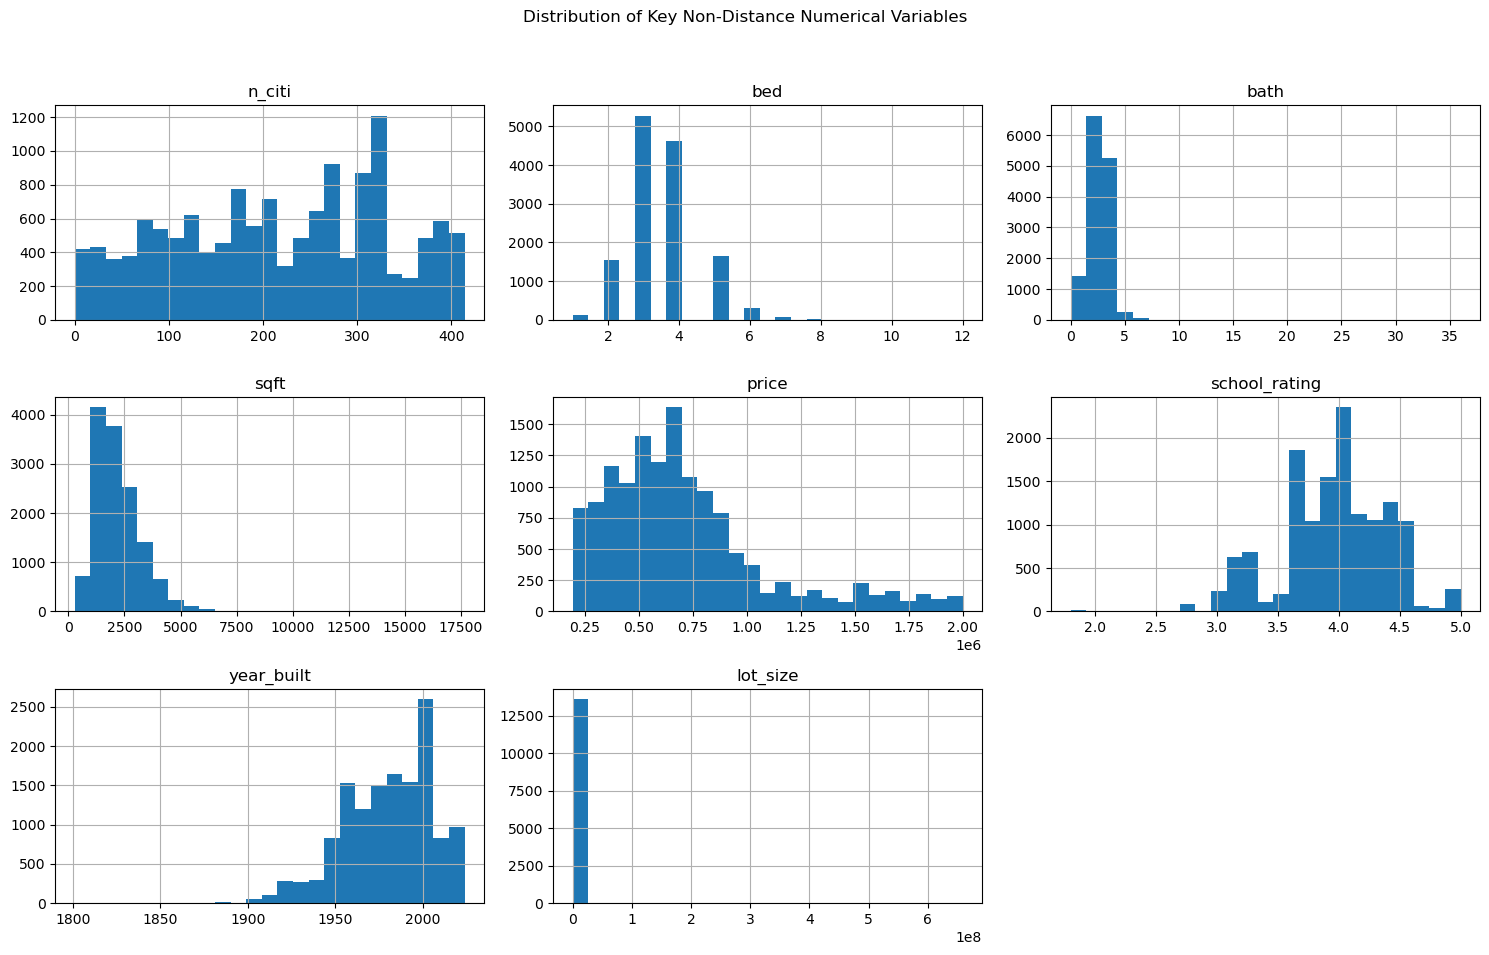

In [ ]:
# Non distance columns
non_distance_cols = ['n_citi', 'bed', 'bath', 'sqft', 'price', 'population', 'income', 
                     'poverty', 'school_rating','year_built', 'lot_size']


# Plot histograms 
houses_data[non_distance_cols].hist(bins=25, figsize=(15, 10))
plt.suptitle("Distribution of Key Non-Distance Numerical Variables")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


## Correlation Matrix

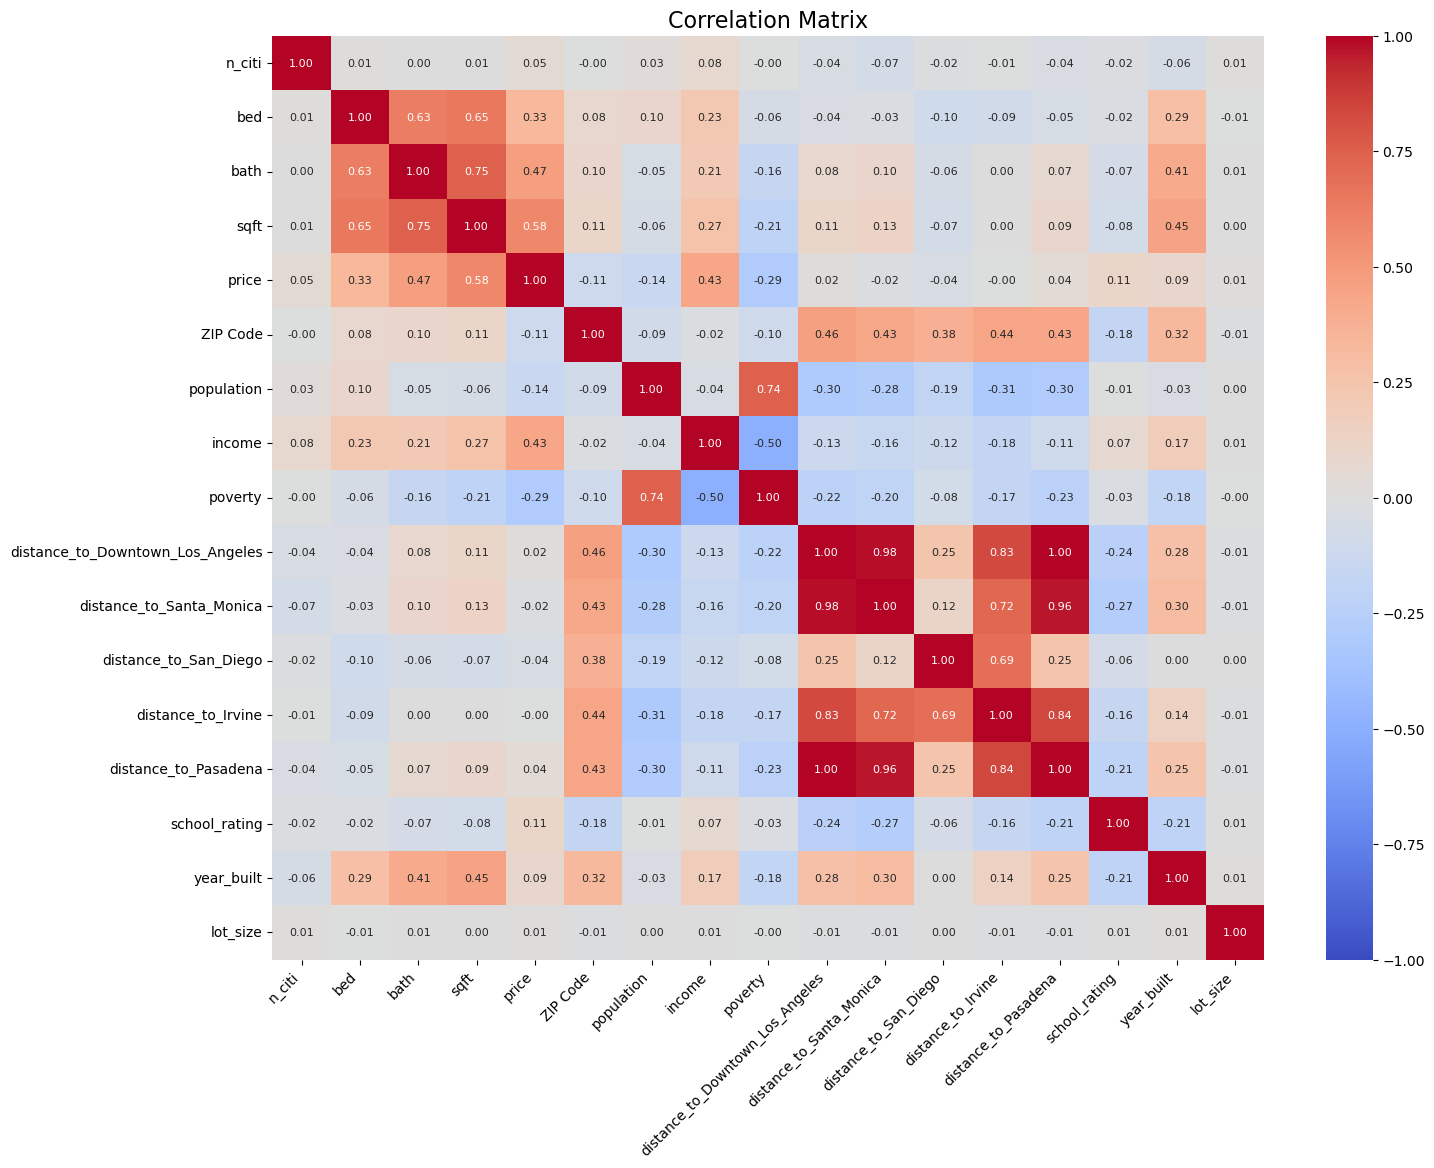

In [392]:
# Define the numerical columns
numerical_cols = [
    'n_citi', 'bed', 'bath', 'sqft', 'price', 'ZIP Code', 'population', 
    'income', 'poverty', 'distance_to_Downtown_Los_Angeles', 
    'distance_to_Santa_Monica', 'distance_to_San_Diego', 
    'distance_to_Irvine', 'distance_to_Pasadena','school_rating','year_built',
    'lot_size'
]

plt.figure(figsize=(16, 12))

# Compute correlation matrix and create heatmap
correlation_matrix = houses_data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.savefig("correlation_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


## Housing location heat map

In [394]:
# Initialize the map centered on Southern California
map_socal = folium.Map(location=[34.05, -118.25], zoom_start=9)

heatmap_data = houses_data[['latitude', 'longitude']].values.tolist()
HeatMap(heatmap_data).add_to(map_socal)
map_socal.save("map_socal.html")

print("Map has been saved as 'map_socal.html'")


Map has been saved as 'map_socal.html'


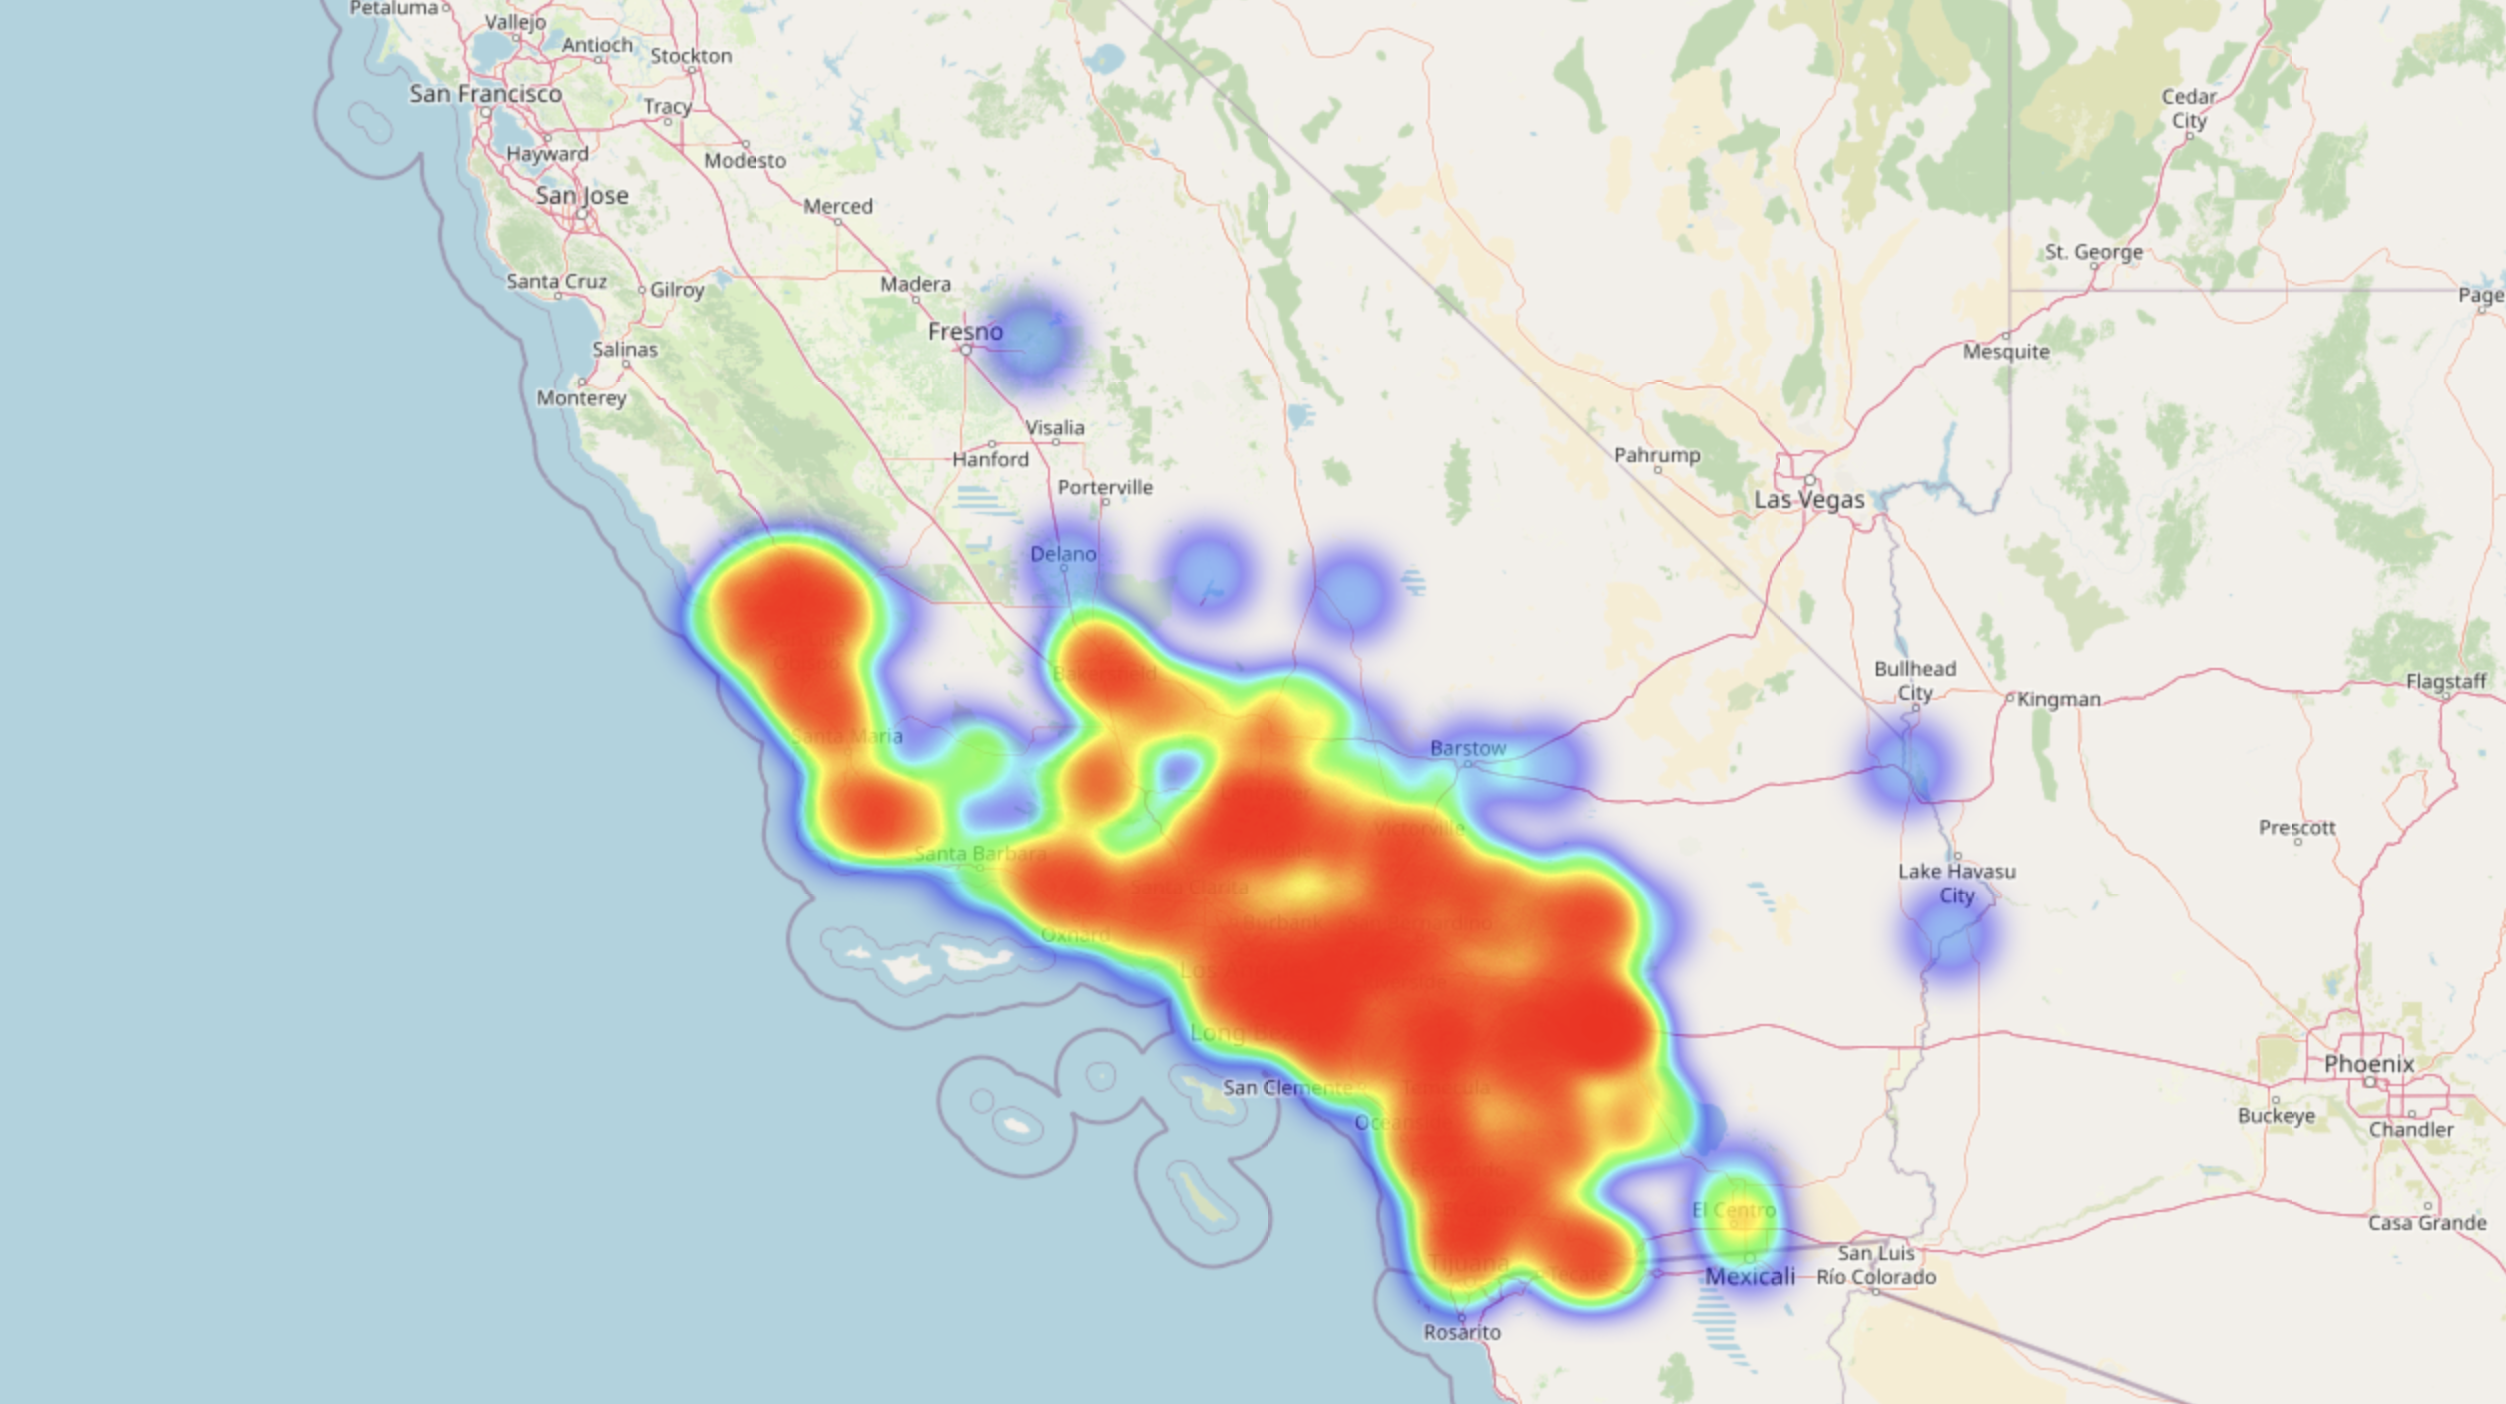

## Housing price quantile distribution

In [396]:
# Calculate price quantiles
q1, q2, q3 = houses_data['price'].quantile([0.25, 0.5, 0.75])
print(f"Price Quantiles:")
print(f"Q1 (25th Percentile): ${q1:,.2f}")
print(f"Median (50th Percentile): ${q2:,.2f}")
print(f"Q3 (75th Percentile): ${q3:,.2f}")

# Define get_color function to assign colors based on quantile
def get_color(price):
    if price <= q1:
        return 'green'  
    elif price <= q2:
        return 'blue'
    elif price <= q3:
        return 'orange' 
    else:
        return 'red' 


map_socal = folium.Map(location=[34.05, -118.25], zoom_start=9)
for _, row in houses_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=1,  
        color=get_color(row['price']),
        fill=True,
        fill_opacity=1, 
        fill_color=get_color(row['price']),
        popup=f"Price: ${row['price']:,}" 
    ).add_to(map_socal)

# Save the map
map_socal.save("socal_price_quantiles_map.html")
print("Map saved as 'socal_price_quantiles_map.html'")


Price Quantiles:
Q1 (25th Percentile): $449,900.00
Median (50th Percentile): $649,000.00
Q3 (75th Percentile): $849,000.00
Map saved as 'socal_price_quantiles_map.html'


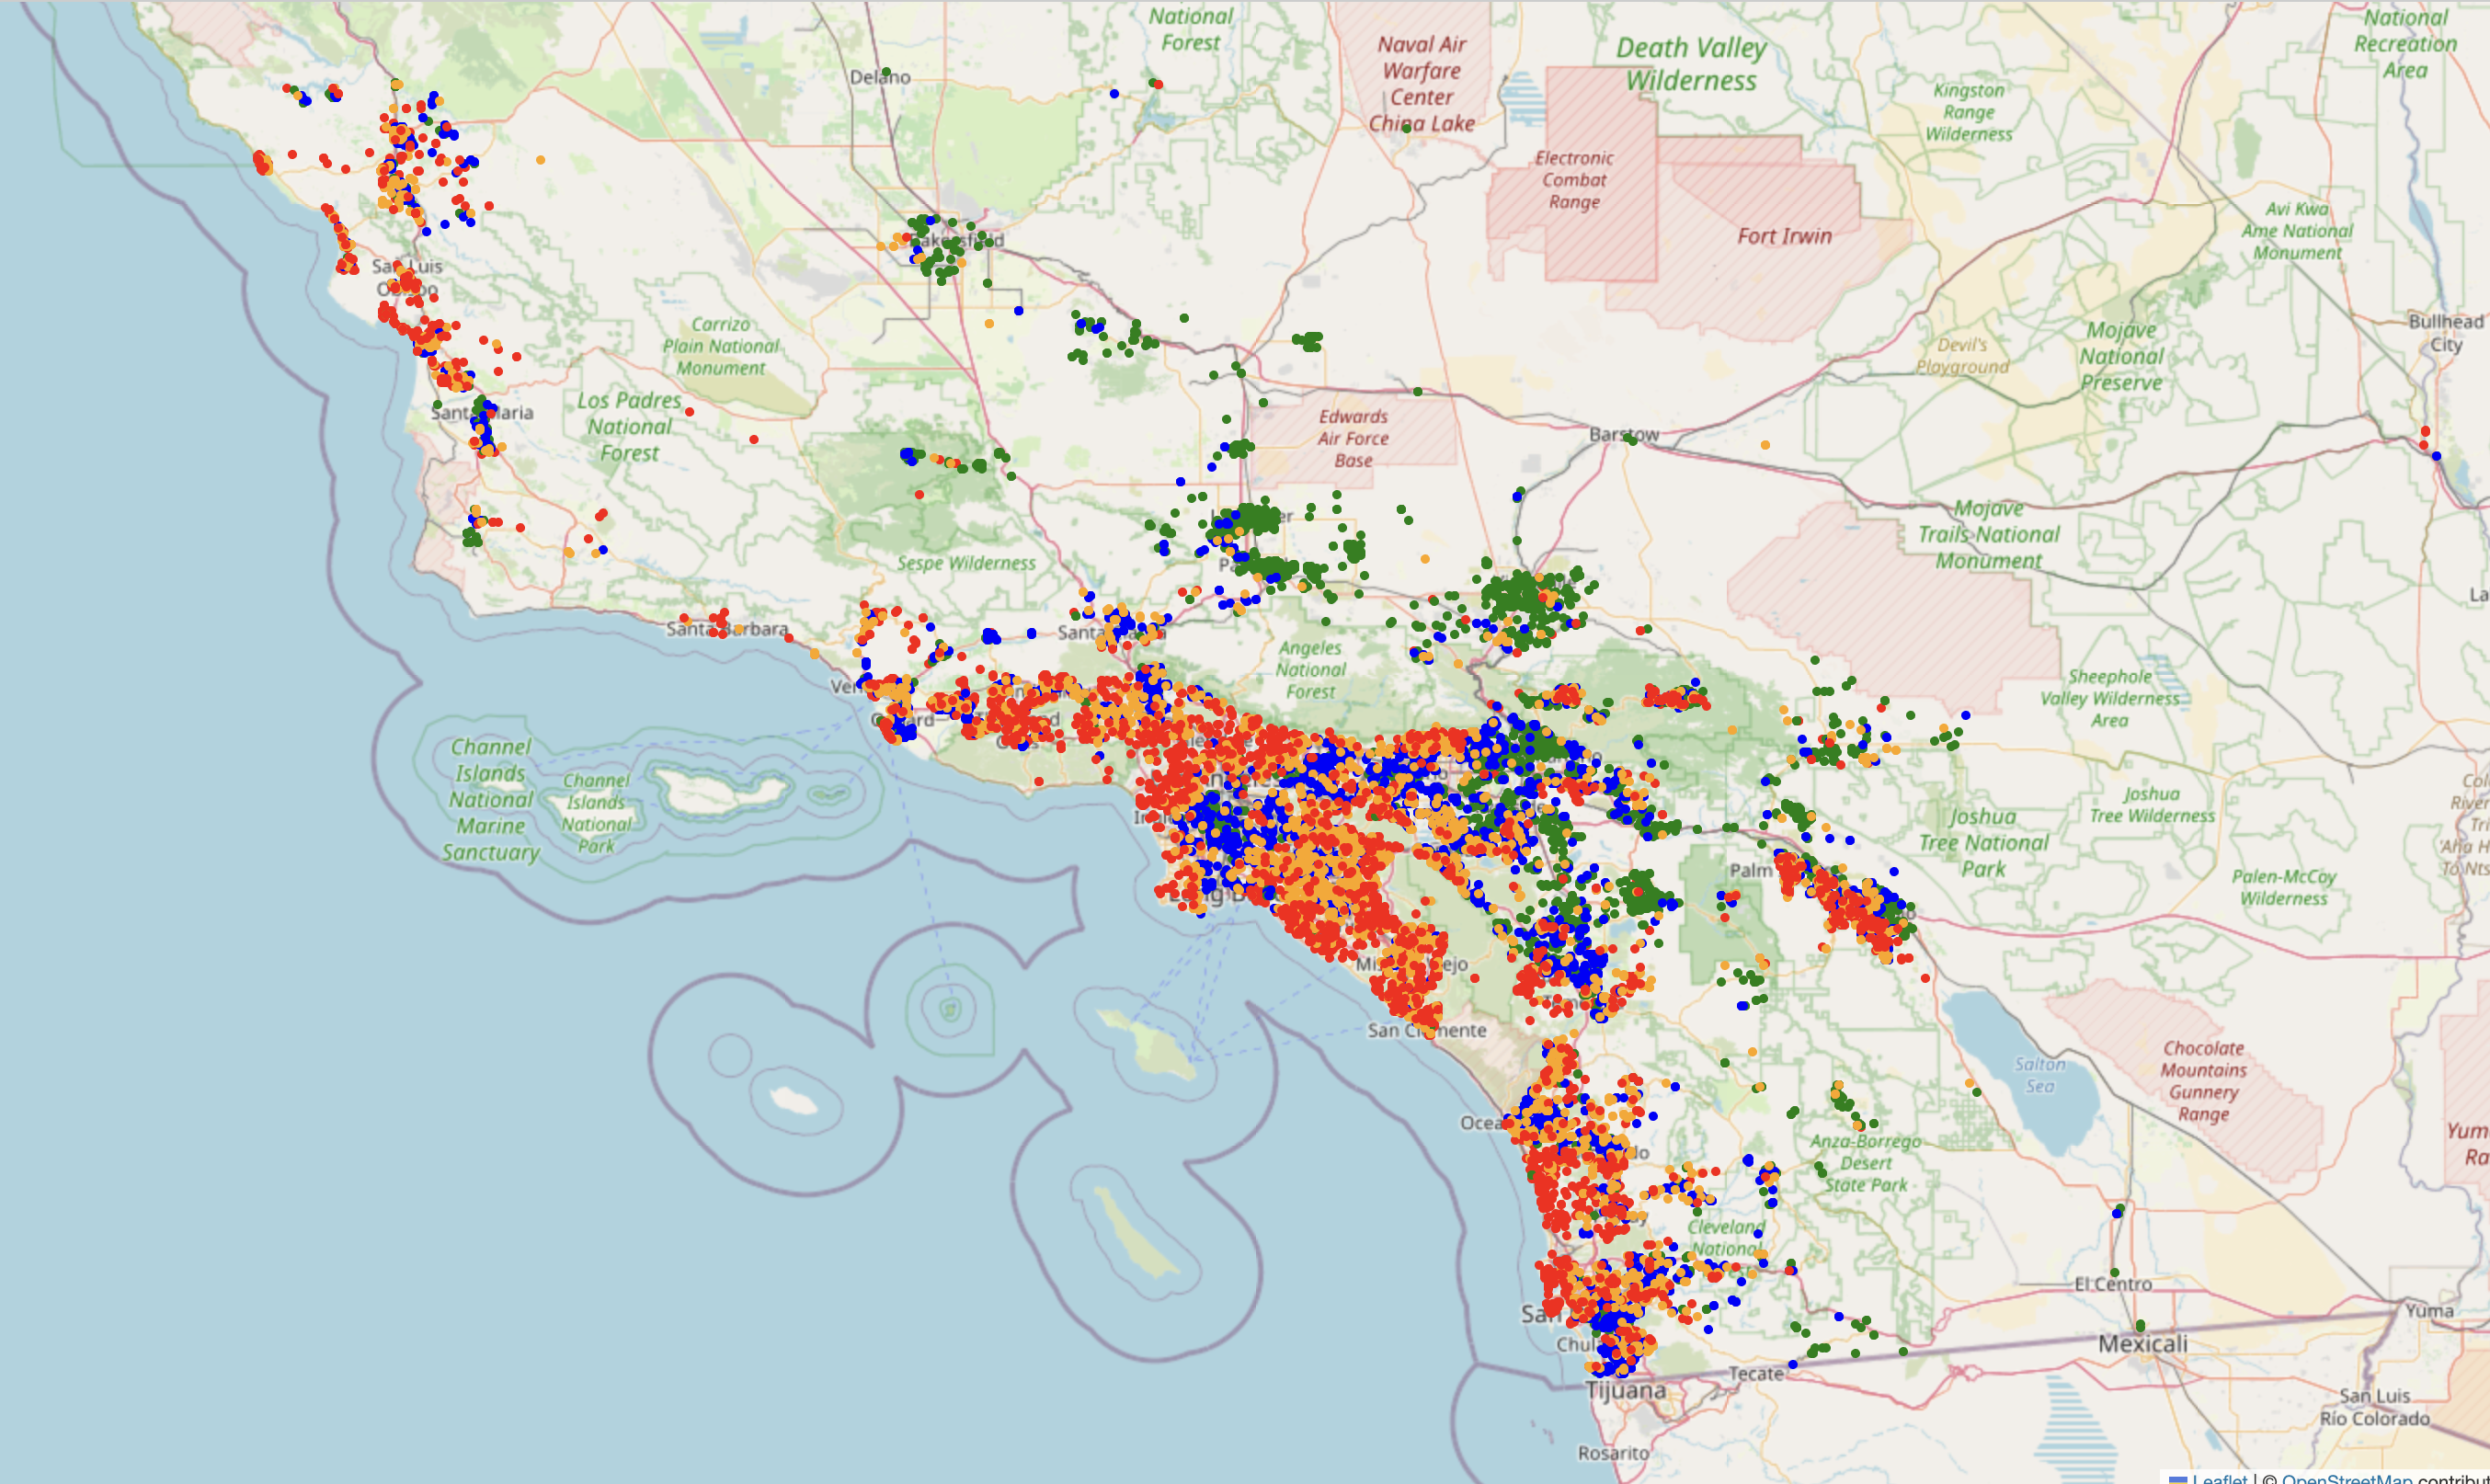

## Plot number of bedroom and bathroom distribution

/var/folders/1d/8hpmq44s11z3gs53y4nck4y80000gn/T/ipykernel_2600/1725974115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses_data['bath_rounded'] = np.round(houses_data['bath']).astype(int)


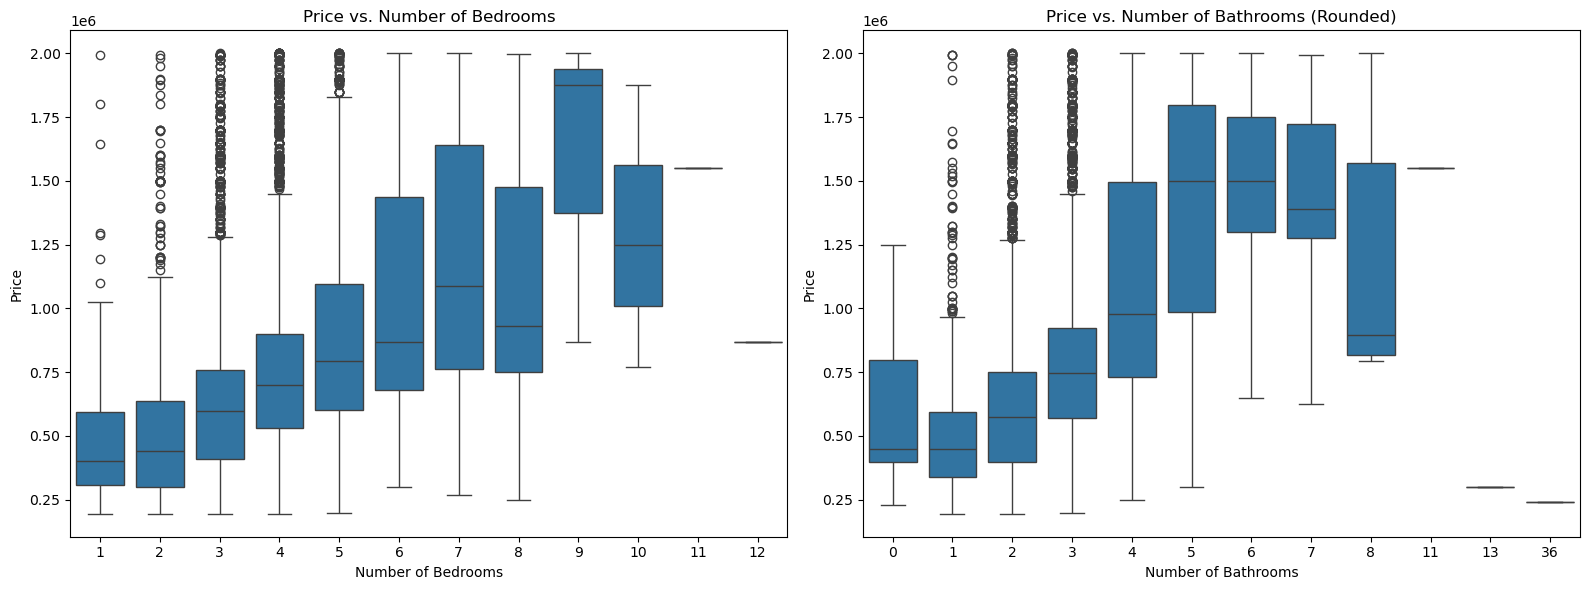

In [397]:
houses_data['bath_rounded'] = np.round(houses_data['bath']).astype(int)  

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for Price vs. Bedrooms
sns.boxplot(x='bed', y='price', data=houses_data, ax=axes[0])
axes[0].set_title('Price vs. Number of Bedrooms')
axes[0].set_xlabel('Number of Bedrooms')
axes[0].set_ylabel('Price')

# Boxplot for Price vs. Bathrooms
sns.boxplot(x='bath_rounded', y='price', data=houses_data, ax=axes[1])
axes[1].set_title('Price vs. Number of Bathrooms (Rounded)')
axes[1].set_xlabel('Number of Bathrooms')
axes[1].set_ylabel('Price')


plt.tight_layout()
plt.show()


## Plot income vs log_price and sqft vs log_price

/var/folders/1d/8hpmq44s11z3gs53y4nck4y80000gn/T/ipykernel_2600/4064113155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses_data['price'] = pd.to_numeric(houses_data['price'], errors='coerce')
/var/folders/1d/8hpmq44s11z3gs53y4nck4y80000gn/T/ipykernel_2600/4064113155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses_data['income'] = pd.to_numeric(houses_data['income'], errors='coerce')
/var/folders/1d/8hpmq44s11z3gs53y4nck4y80000gn/T/ipykernel_2600/4064113155.py:4: SettingWithCopyWarning:

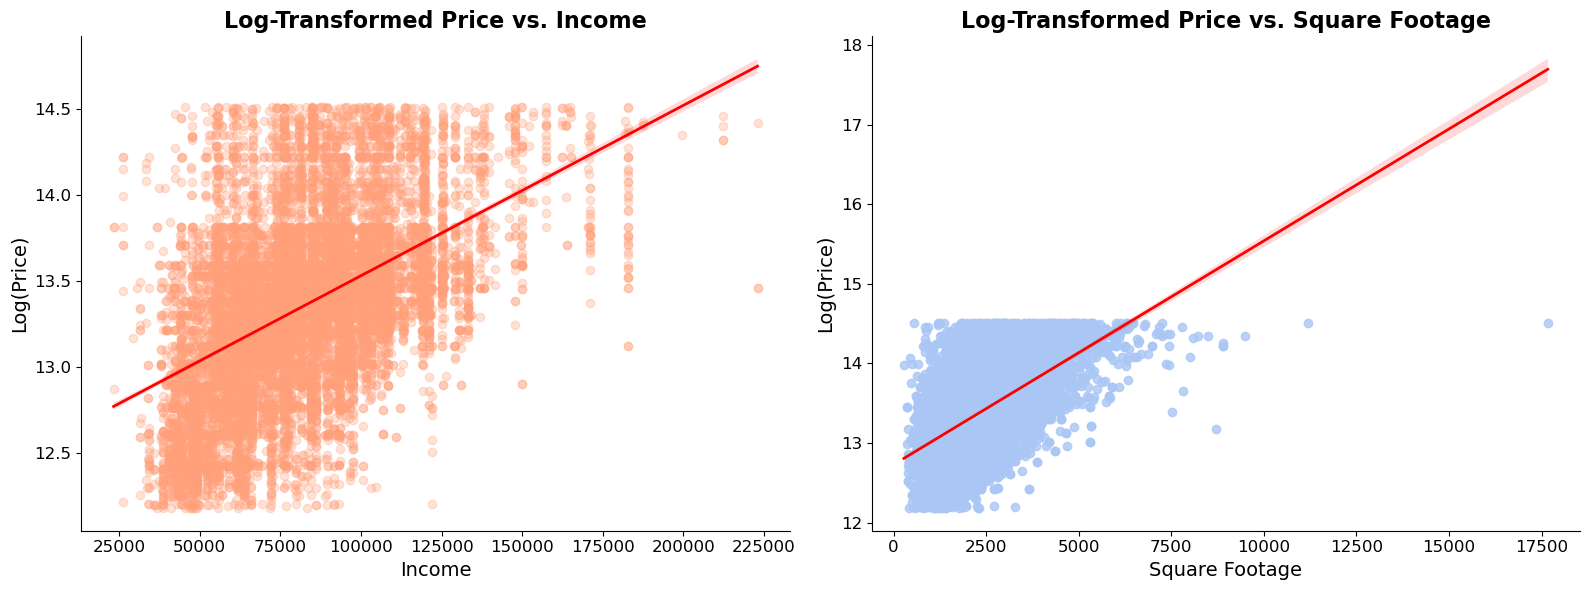

In [400]:
# Add 'log_price' column
houses_data['price'] = pd.to_numeric(houses_data['price'], errors='coerce')
houses_data['income'] = pd.to_numeric(houses_data['income'], errors='coerce')
houses_data['log_price'] = np.log(houses_data['price'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 

# Plot 1: Log Price vs. Income
sns.regplot(
    x='income', 
    y='log_price', 
    data=houses_data, 
    ax=axes[0], 
    scatter_kws={'alpha': 0.3, 'color': '#FFA07A'}, 
    line_kws={'color': 'red', 'linewidth': 2} 
)
axes[0].set_title('Log-Transformed Price vs. Income', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Income', fontsize=14)
axes[0].set_ylabel('Log(Price)', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
sns.despine(ax=axes[0])

# Plot 2: Log Price vs. Square Footage
sns.regplot(
    x='sqft', 
    y='log_price', 
    data=houses_data, 
    ax=axes[1],
    scatter_kws={'alpha': 0.8, 'color': '#A9C6F5'},  
    line_kws={'color': 'red', 'linewidth': 2}
)
axes[1].set_title('Log-Transformed Price vs. Square Footage', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Square Footage', fontsize=14)
axes[1].set_ylabel('Log(Price)', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
sns.despine(ax=axes[1])
plt.tight_layout()
plt.show()


## Plot Price & Log_price Distribution

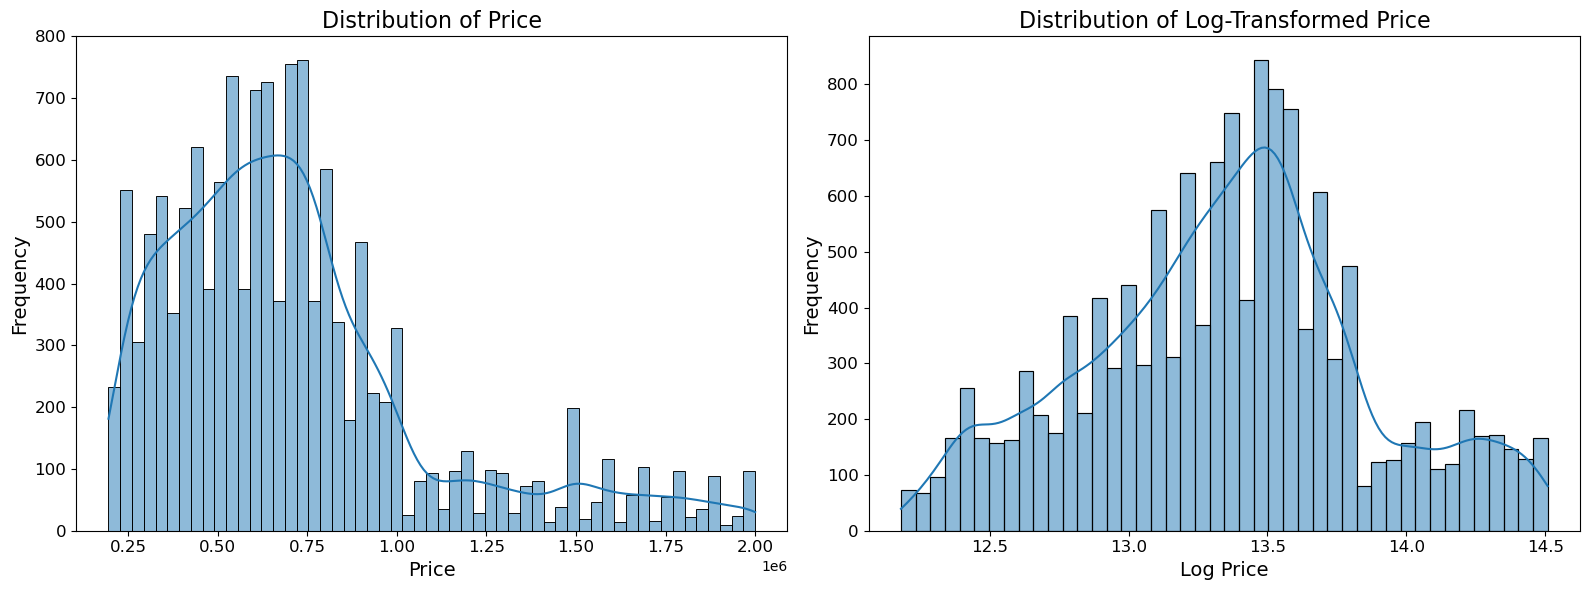

In [402]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Distribution of Price
sns.histplot(houses_data['price'], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Price", fontsize=16)
axes[0].set_xlabel("Price", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)

# Plot 2: Distribution of Log-Transformed Price
sns.histplot(houses_data['log_price'], kde=True, ax=axes[1])
axes[1].set_title("Distribution of Log-Transformed Price", fontsize=16)
axes[1].set_xlabel("Log Price", fontsize=14)
axes[1].set_ylabel("Frequency", fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Test-Train-Validation Split

In [404]:
# 80/20 train test split
train_data, test_data = train_test_split(houses_data, test_size=0.2, random_state=42)

# Further split the train data into 80/20 validation
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Print the sizes to confirm
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

train_data.to_csv('train_set.csv')
val_data.to_csv('val_set.csv')
test_data.to_csv('test_set.csv')

Training set size: 8723
Validation set size: 2181
Test set size: 2727
